##1. Problem Statement
Customer churn refers to the loss of customers over time. For subscription-based businesses (e.g., telecom, streaming services), reducing churn is critical for maintaining
revenue and growth.

In this project, we aim to predict which customers are likely to churn using logistic regression while exploring multiple approaches to optimize performance and interpretability.

##2. Dataset Selection
We will use the Telco Customer Churn Dataset from Kaggle (link ). This dataset contains information about customer demographics, services subscribed, payment methods, and churn status.

Key Features:
Demographics : Gender, age group, partner, dependents.
Services : Phone service, internet service, streaming TV, etc.
Billing : Monthly charges, total charges, payment method.
Churn Label : Whether the customer has churned (Yes/No).


In [16]:
!pip install opendatasets

In [17]:
import opendatasets as od

In [18]:
od.download("https://www.kaggle.com/datasets/blastchar/telco-customer-churn?spm=5aebb161.2ef5001f.0.0.14b0c921qxddDT")

Skipping, found downloaded files in "./telco-customer-churn" (use force=True to force download)


##Load and little Explore

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [20]:
data = pd.read_csv('/content/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [21]:
print(data.info())
print(data.describe())
print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


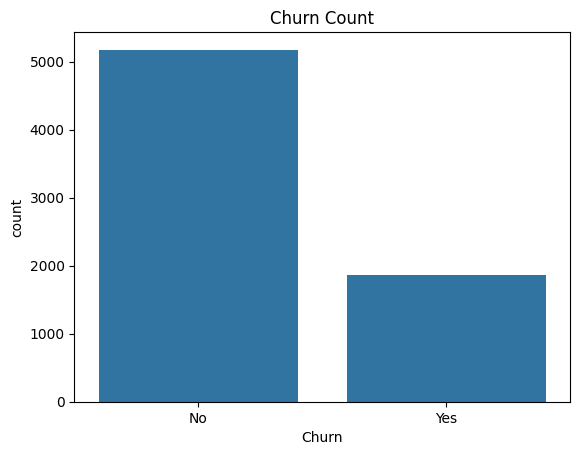

In [22]:
sns.countplot (x="Churn",data = data)
plt.title("Churn Count")
plt.show()

##Data Preprocessing

In [23]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)

<ipython-input-23-b698680ce3b7>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)


In [24]:
print(data.isnull().sum())

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [25]:
data['Churn'] = data['Churn'].map({'Yes': 1 , 'No': 0})

print(data['Churn'].value_counts(normalize = True))

Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64


In [26]:
categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
                        'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                        'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                        'Contract', 'PaperlessBilling', 'PaymentMethod']


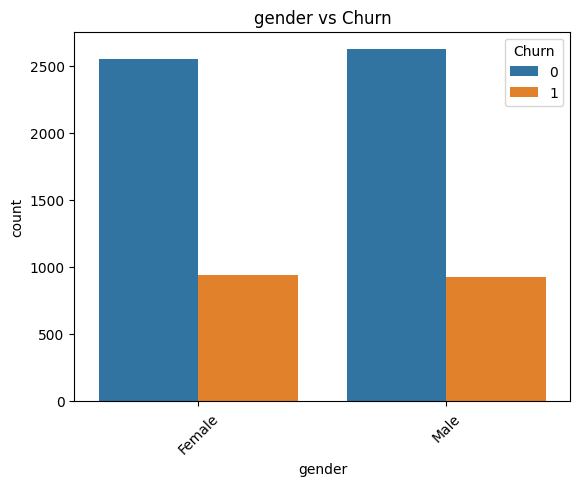

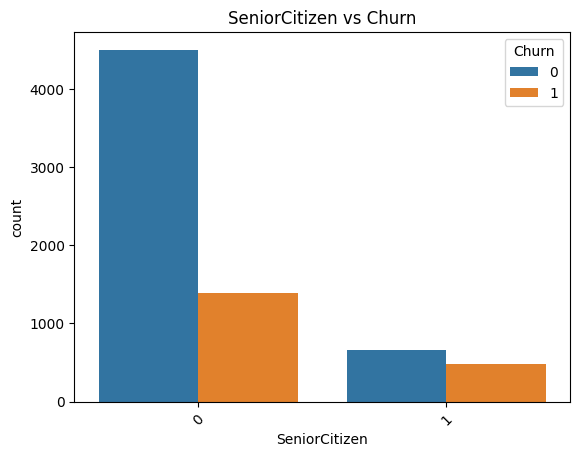

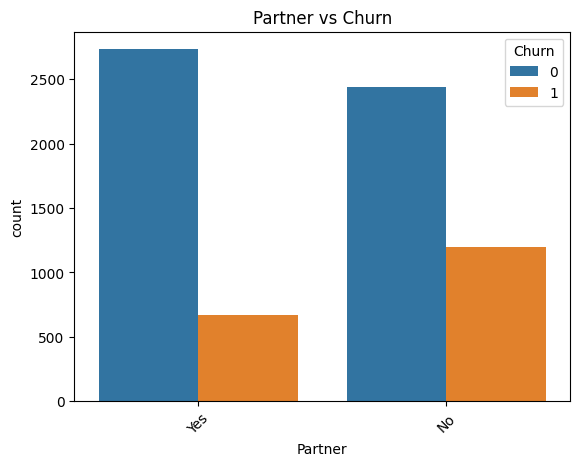

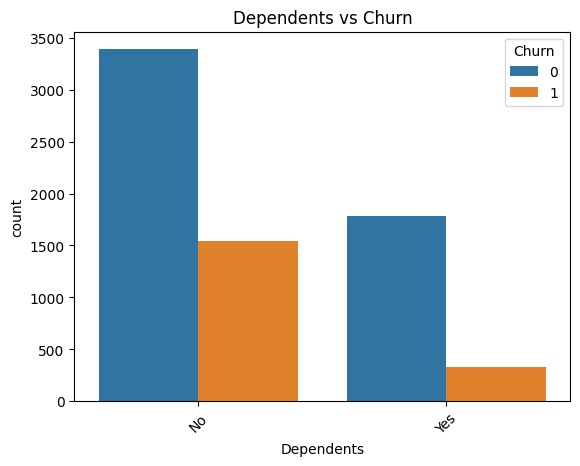

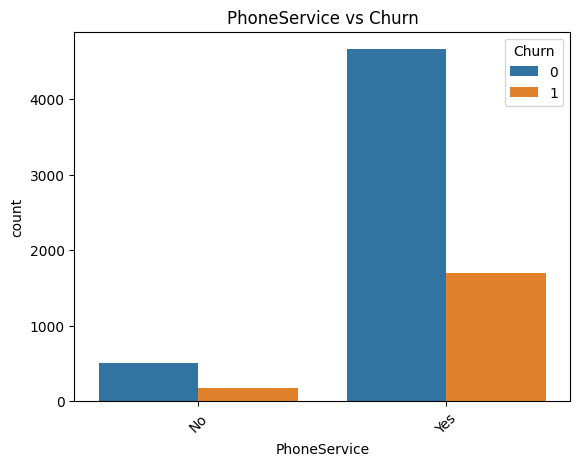

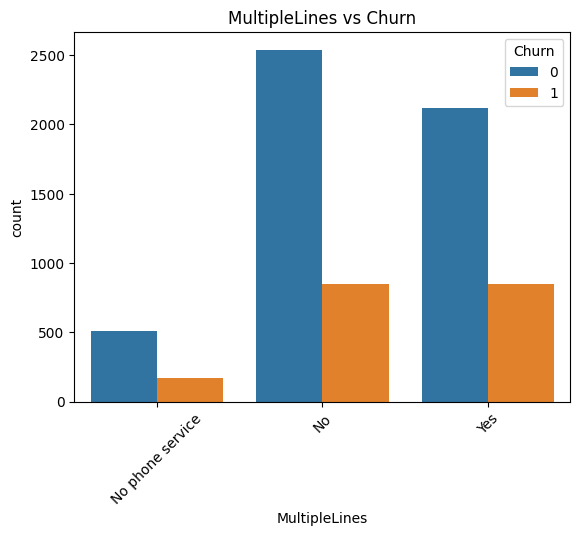

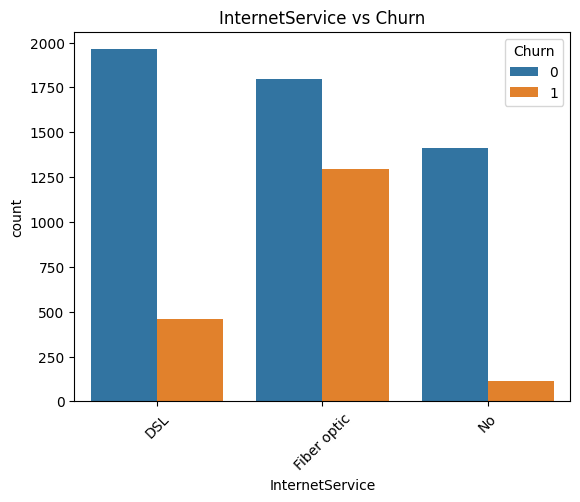

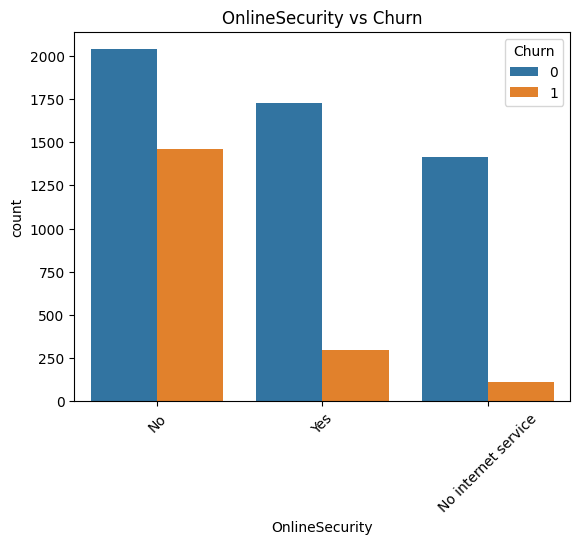

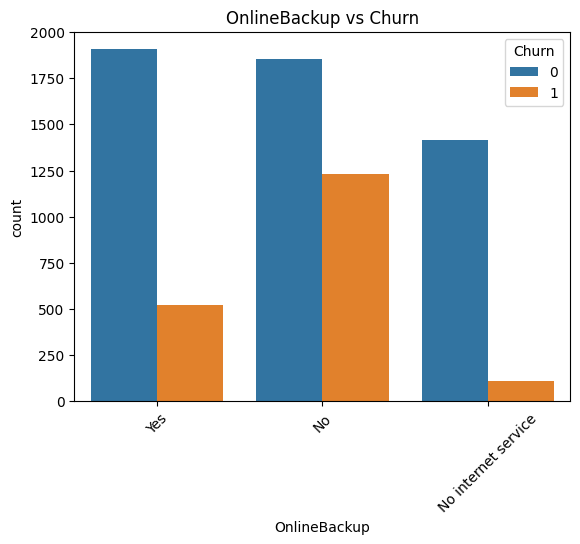

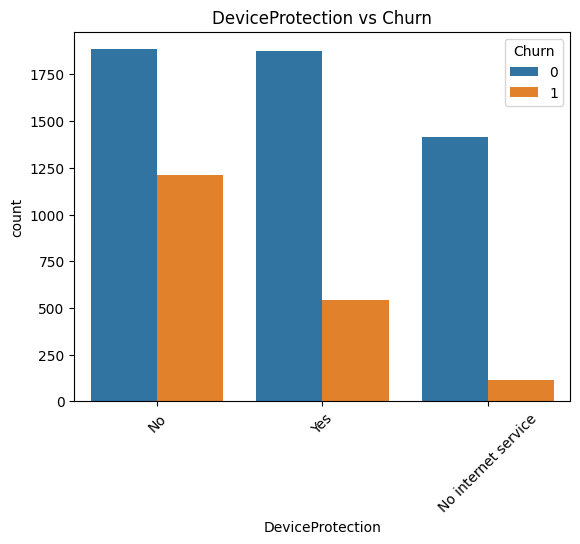

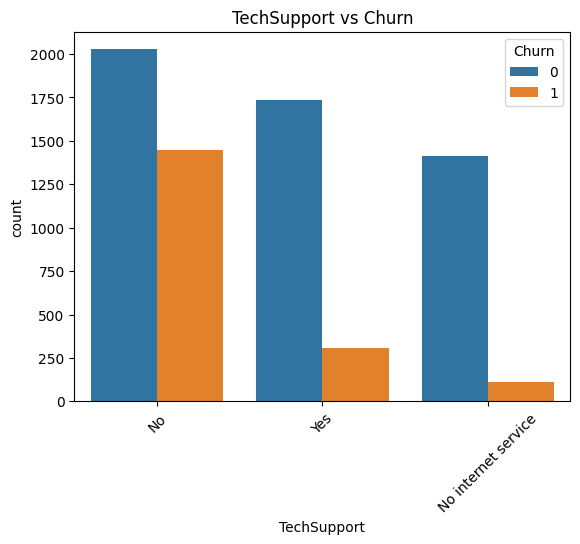

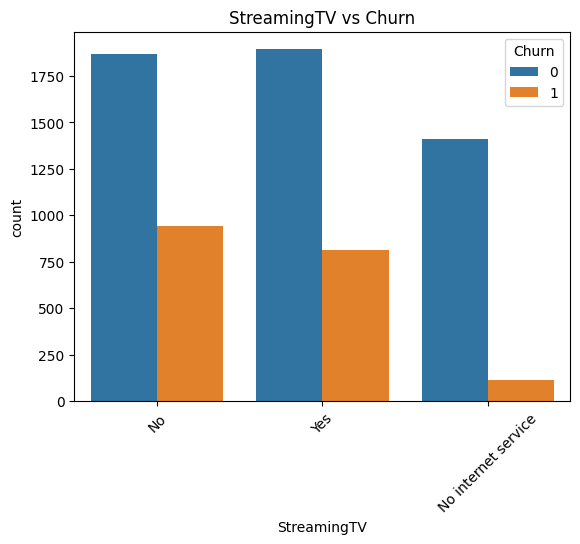

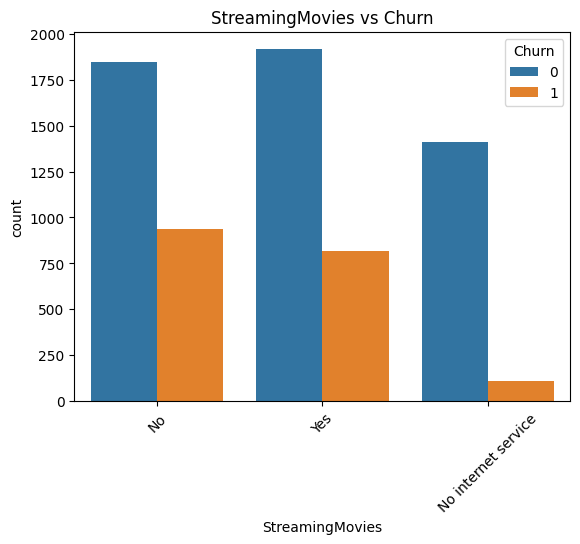

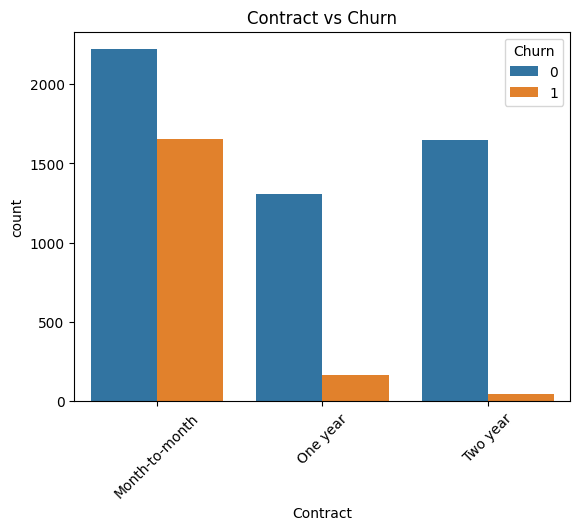

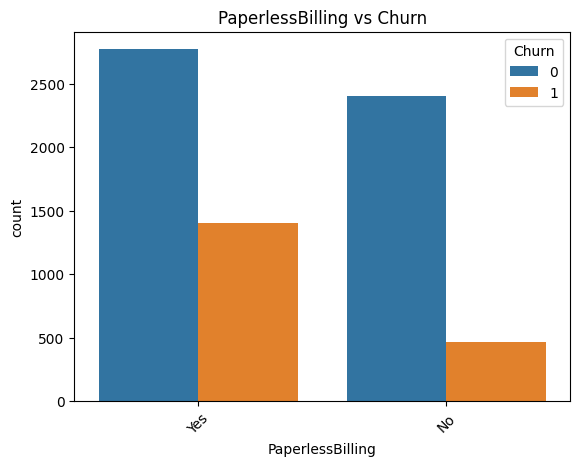

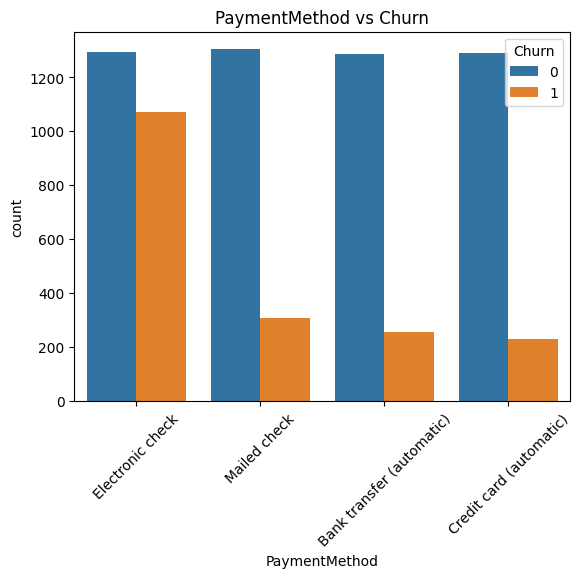

In [27]:
for feature in categorical_features:
  sns.countplot(x= feature,hue= 'Churn',data = data)
  plt.title(f"{feature} vs Churn")
  plt.xticks(rotation = 45)
  plt.show()

In [28]:
print(data[['tenure', 'MonthlyCharges', 'TotalCharges']].describe())

            tenure  MonthlyCharges  TotalCharges
count  7043.000000     7043.000000   7043.000000
mean     32.371149       64.761692   2281.916928
std      24.559481       30.090047   2265.270398
min       0.000000       18.250000     18.800000
25%       9.000000       35.500000    402.225000
50%      29.000000       70.350000   1397.475000
75%      55.000000       89.850000   3786.600000
max      72.000000      118.750000   8684.800000


In [29]:
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']


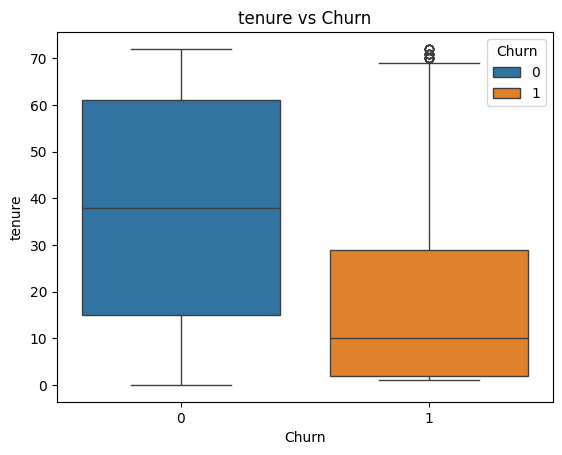

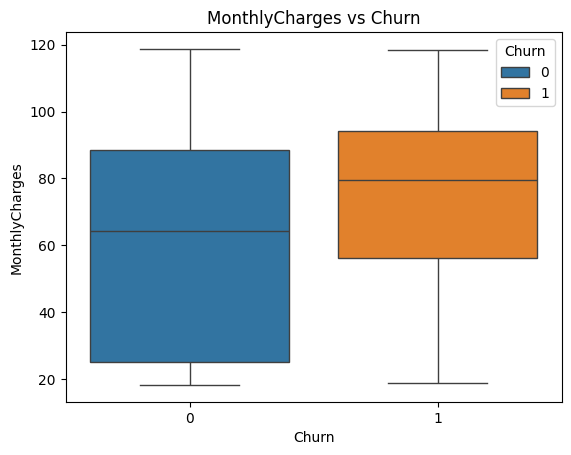

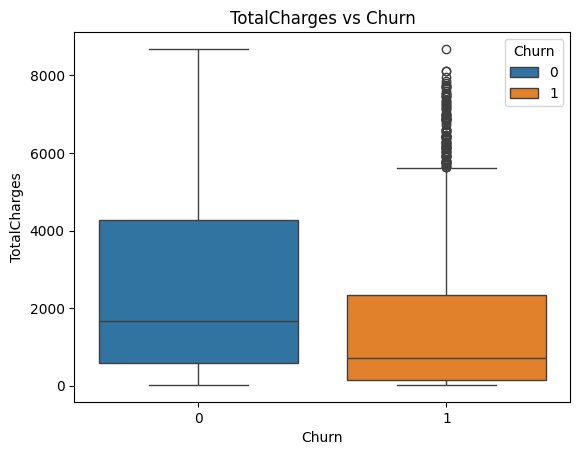

In [31]:
for feature in numerical_features:
  sns.boxplot(x='Churn',y = feature,data  = data,hue = 'Churn')
  plt.title(f"{feature} vs Churn")
  plt.show()

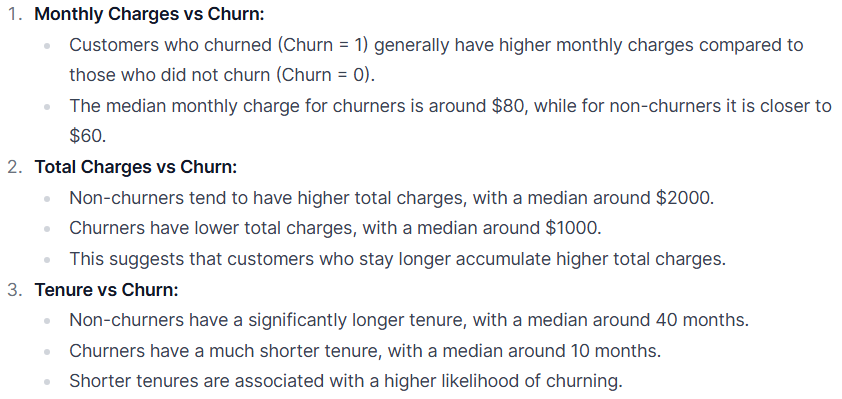

###Feature Engineering

In [33]:
def tenure_group(tenure):
    if tenure < 12:
        return 'New'
    elif 12 <= tenure <= 48:
        return 'Mid-term'
    else:
        return 'Long-term'

data['TenureGroup'] = data['tenure'].apply(tenure_group)

In [34]:
data['CostToValueRatio'] = data['TotalCharges'] / (data['tenure'] + 1)  # Avoid division by zero

In [36]:
from sklearn.model_selection import train_test_split



In [37]:
X = data.drop(columns = ['customerID',"Churn"])
y = data['Churn']

In [38]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.27,random_state=42)

In [40]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Define categorical and numerical features
categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
                        'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                        'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                        'Contract', 'PaperlessBilling', 'PaymentMethod', 'TenureGroup']

numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'CostToValueRatio']

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', solver='liblinear'))
])

# Train the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges',
                                                   'CostToValueRatio']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod',
                                                   'TenureGroup'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced',
                                    solver='liblinear'))])

In [45]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


In [46]:
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

In [47]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.74      0.82      1385
           1       0.54      0.83      0.65       517

    accuracy                           0.76      1902
   macro avg       0.73      0.78      0.74      1902
weighted avg       0.82      0.76      0.78      1902



In [53]:
# Access the logistic regression model from the pipeline
classifier = pipeline.named_steps['classifier']

# Extract coefficients and feature names
coefficients = classifier.coef_[0]  # Coefficients for binary classification
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numerical_features, ohe_feature_names])

# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({'Feature': all_feature_names, 'Coefficient': coefficients})

# Sort by absolute coefficient values (to show most impactful features)
feature_importance = feature_importance.reindex(feature_importance['Coefficient'].abs().sort_values(ascending=False).index)

# Display top 5 features
print(feature_importance.head())

                        Feature  Coefficient
3              CostToValueRatio    -1.885660
26            Contract_Two year    -1.748470
11  InternetService_Fiber optic     1.189091
0                        tenure    -0.836496
25            Contract_One year    -0.689041


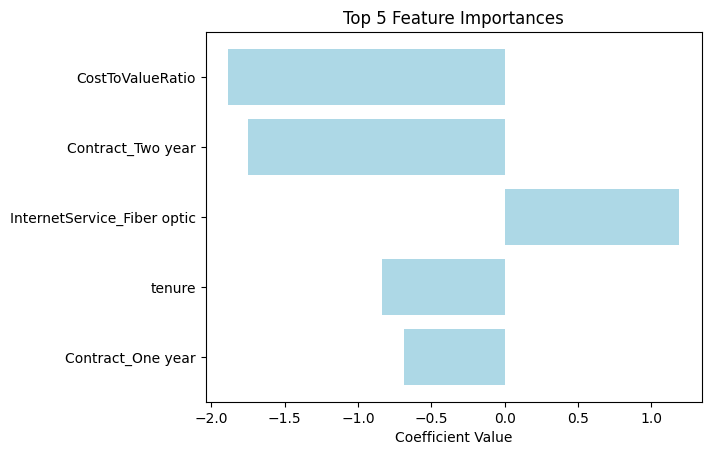

In [54]:
import matplotlib.pyplot as plt

# Plot top 5 features
top_features = feature_importance.head()
plt.barh(top_features['Feature'], top_features['Coefficient'], color='lightblue')
plt.title("Top 5 Feature Importances")
plt.xlabel("Coefficient Value")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

The model performs better in identifying non-churn cases (Class 0) than churn cases (Class 1), as indicated by the higher precision and F1-score for Class 0.

There is a significant drop in precision for Class 1, suggesting that the model may be overpredicting churn, leading to many false positives.

The weighted averages are influenced more by the larger class (non-churn), which has more instances (1385 vs. 517).

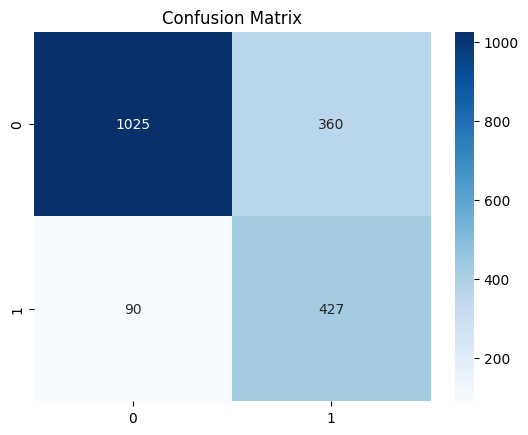

In [50]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

True Negatives (TN): 1025 - The number of instances correctly predicted as non-churn.

False Positives (FP): 90 - The number of instances incorrectly predicted as churn when they are actually non-churn.

False Negatives (FN): 360 - The number of instances incorrectly predicted as non-churn when they are actually churn.

True Positives (TP): 427 - The number of instances correctly predicted as churn.

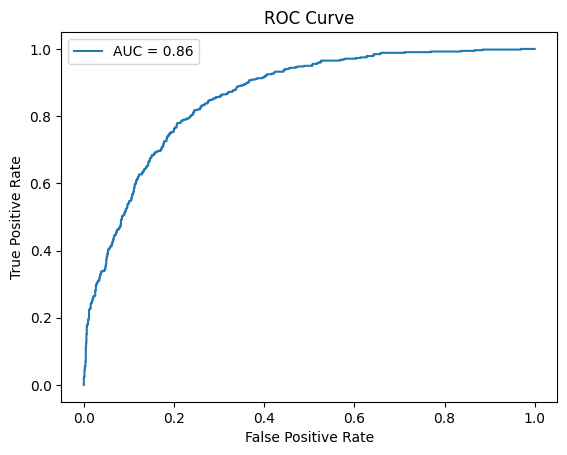

In [51]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

AUC (Area Under the Curve) value is 0.86, which indicates a good discriminatory ability of the model.

An AUC of 0.86 suggests that the model has a strong ability to distinguish between the two classes.

The curve starts steeply from the origin, indicating that the model achieves a high TPR with a relatively low FPR, which is desirable.

As the curve approaches the top-right corner, it flattens out, showing that the model maintains a good balance between TPR and FPR even as the threshold changes.

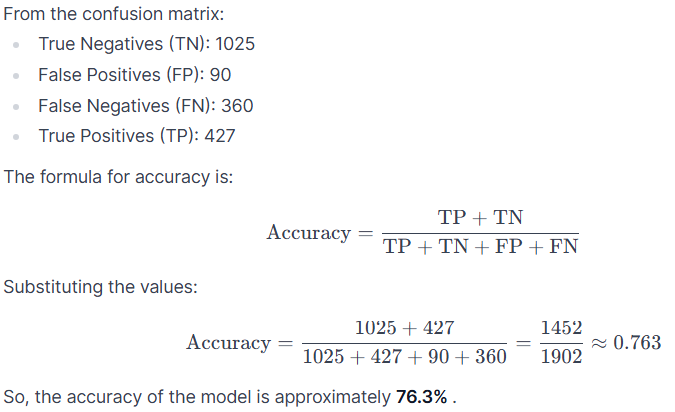

In [55]:
import joblib
joblib.dump(pipeline,'churn_model.pkl')

['churn_model.pkl']